In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import re
import sys
import os

In [35]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty and np.isfinite(data).all():
            margin = 0.05 * (data.max() - data.min()) if data.max() != data.min() else 0.5
            x_min = data.min() - margin
            x_max = data.max() + margin
            
            # Graficamos el histograma usando bins automáticos para mejor adaptación
            sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
            axes[idx].set_title(f'Distribución de {col}')
            
            # Solo establecer límites si son finitos
            if np.isfinite(x_min) and np.isfinite(x_max):
                axes[idx].set_xlim(x_min, x_max)
        else:
            # Si no hay datos válidos o contiene infinitos/NaN
            axes[idx].text(0.5, 0.5, 'No hay datos válidos para graficar',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[idx].transAxes)
            axes[idx].set_title(f'Distribución de {col}')

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        # Filtrar columnas numéricas que contienen valores infinitos o NaN
        valid_numeric_cols = []
        for col in numeric_cols:
            if df[col].dropna().empty or not np.isfinite(df[col].dropna()).all():
                print(f"Advertencia: La columna '{col}' contiene valores no finitos y no será graficada.")
            else:
                valid_numeric_cols.append(col)
        
        if valid_numeric_cols:
            plot_numeric_analysis(df, valid_numeric_cols)
        else:
            print("No hay columnas numéricas válidas para graficar.")
    return

Ya que se descargan los datos sin valores nulos, la data esta limpia y no hay que hacer nada en cuanto a data wrangling. 

|                                                 Análisis de la tabla Apple                                                |
Dimensiones: (11165, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 11165           | 8155               | 10376              | 10187              | 10545              | 10601              | 10790              | 10728              | 10774              | 10478              | 10584              |
| Media     

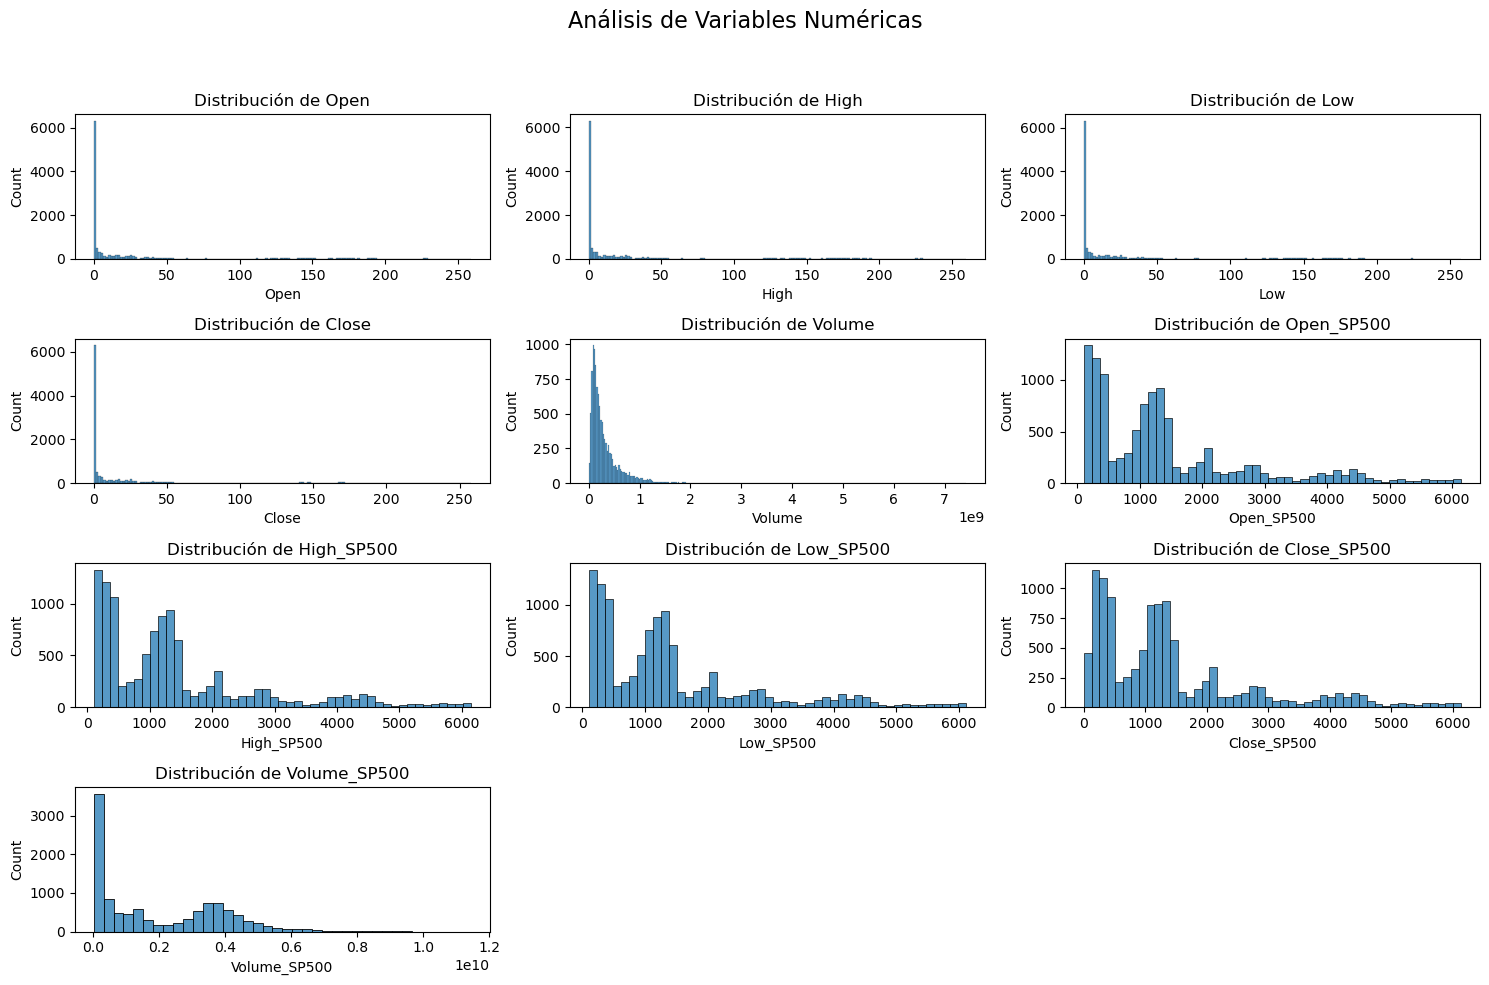

In [36]:
apple_data = pd.read_csv('../data/raw/AAPL_with_SP500.csv')
analisis_exploratorio('Apple', apple_data)

In [37]:
mask_extreme_upper = iqr_method(apple_data['Close'])['extreme_upper']
mask_extreme_lower = iqr_method(apple_data['Close'])['extreme_lower']
mask_outliers_upper = iqr_method(apple_data['Close'])['outliers_upper']
mask_outliers_lower = iqr_method(apple_data['Close'])['outliers_lower']

apple_data['Close'][mask_extreme_upper]

9853      75.197613
9854      75.449414
9855      76.674482
9856      75.500261
9857      75.921521
            ...    
11160    220.770004
11161    223.509995
11162    221.389999
11163    221.669998
11164    217.009995
Name: Close, Length: 1255, dtype: float64

Ya que los outliers no son un porcentaje grande del dataset y parecen data organica y no algún error entonces tampoco hacemos nada

|                                                Análisis de la tabla Amazon                                                |
Dimensiones: (7013, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close             | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 7013            | 6368               | 6229               | 6234               | 6271              | 6818               | 6868               | 6854               | 6861               | 6874               | 6814               |
| Media         

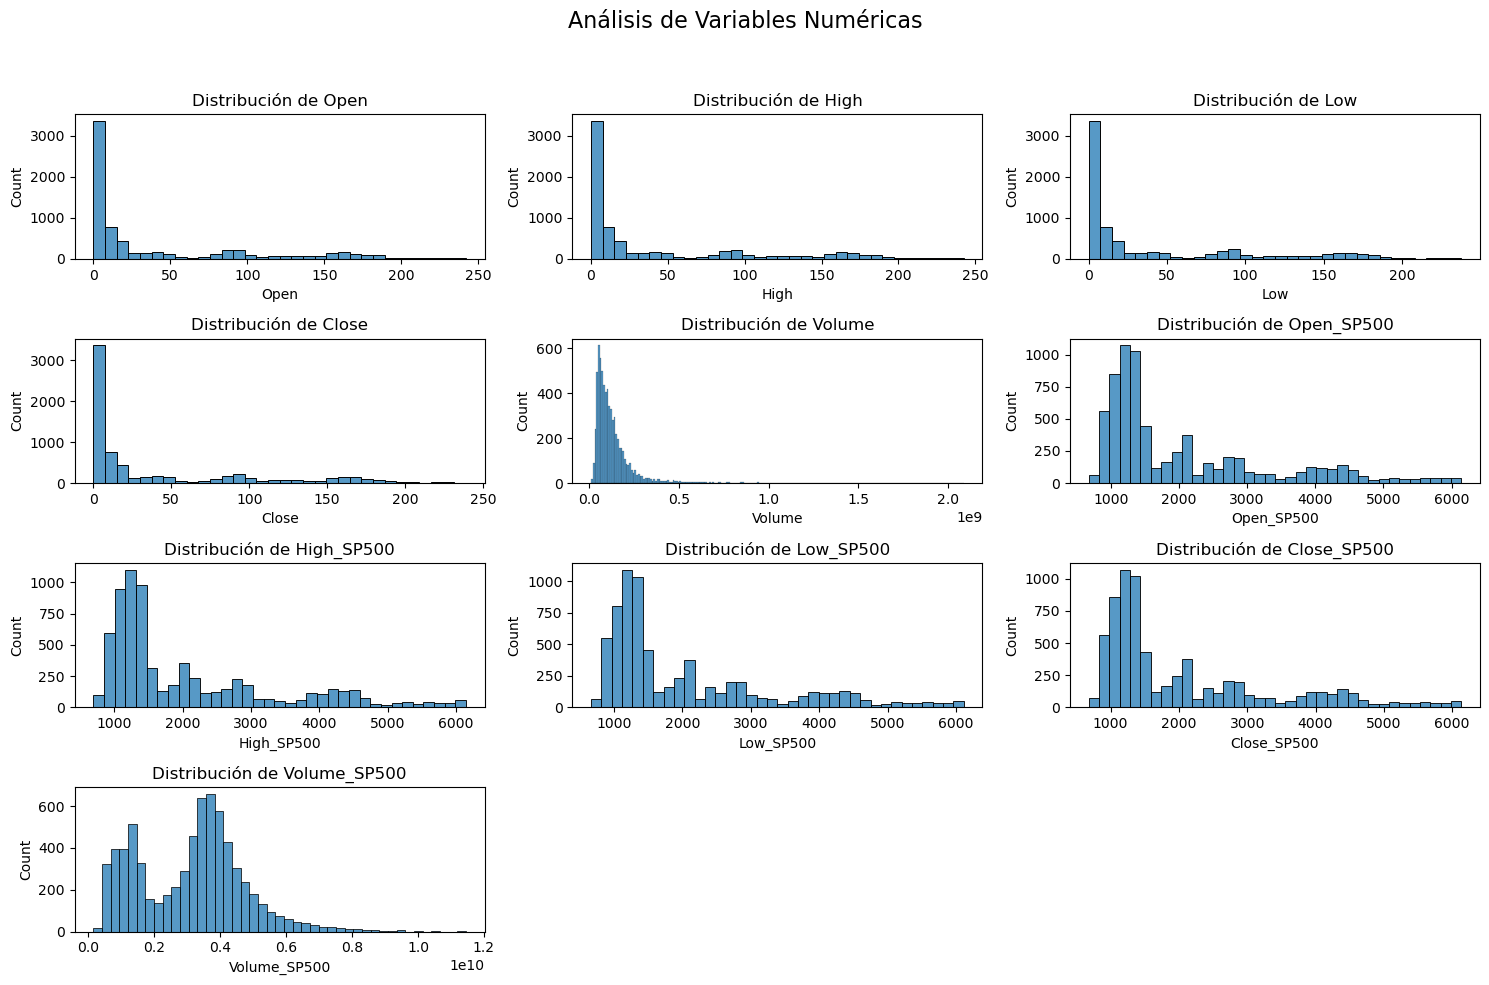

In [38]:
amazon_data = pd.read_csv('../data/raw/AMZN_with_SP500.csv')
analisis_exploratorio('Amazon', amazon_data)

In [39]:
mask_extreme_upper = iqr_method(amazon_data['Close'])['extreme_upper']
mask_extreme_lower = iqr_method(amazon_data['Close'])['extreme_lower']
mask_outliers_upper = iqr_method(amazon_data['Close'])['outliers_upper']
mask_outliers_lower = iqr_method(amazon_data['Close'])['outliers_lower']

amazon_data['Close'][mask_outliers_upper]

6078    187.199997
6767    186.899994
6768    187.240005
6770    186.740005
6771    187.720001
           ...    
7008    203.600006
7009    205.839996
7010    200.889999
7011    198.419998
7012    188.190002
Name: Close, Length: 162, dtype: float64

De igual forma estos outliers tampoco requieren intervención

|                                               Análisis de la tabla Microsoft                                              |
Dimensiones: (9839, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 9839            | 7733               | 9541               | 9534               | 9655               | 9647               | 9570               | 9514               | 9579               | 9570               | 9446               |
| Media      

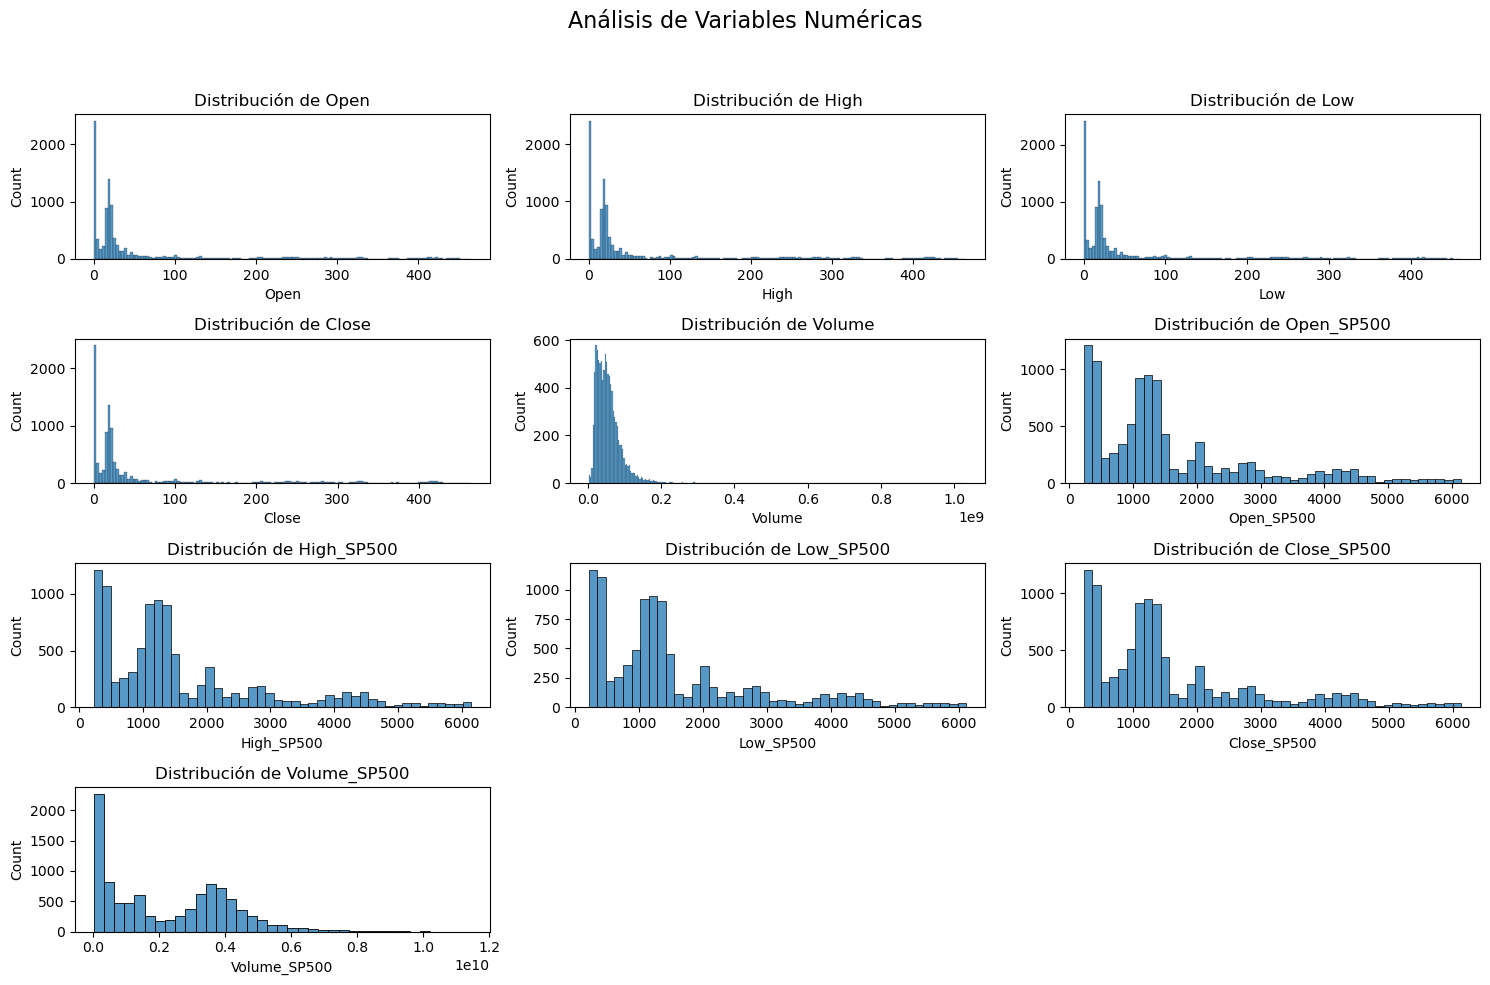

In [40]:
microsoft_data = pd.read_csv('../data/raw/MSFT_with_SP500.csv')
analisis_exploratorio('Microsoft', microsoft_data)

In [41]:
mask_extreme_upper = iqr_method(microsoft_data['Close'])['extreme_upper']
mask_extreme_lower = iqr_method(microsoft_data['Close'])['extreme_lower']
mask_outliers_upper = iqr_method(microsoft_data['Close'])['outliers_upper']
mask_outliers_lower = iqr_method(microsoft_data['Close'])['outliers_lower']

microsoft_data['Close'][mask_extreme_upper]

8518    152.206409
8519    151.767302
8521    151.566880
8522    151.127733
8524    152.082316
           ...    
9834    393.920013
9835    395.000000
9836    390.130005
9837    388.079987
9838    372.540009
Name: Close, Length: 1300, dtype: float64

En este caso igualmente no haremos nada con los outliers

|                                                Análisis de la tabla NVIDIA                                                |
Dimensiones: (6588, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close               | Volume            | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500      |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:--------------------|:------------------|:-------------------|:-------------------|:-------------------|:-------------------|:------------------|
| Valores Únicos                | 6588            | 5546               | 6561               | 6552               | 6571                | 6504              | 6467               | 6455               | 6460               | 6470               | 6405              |
| Media         

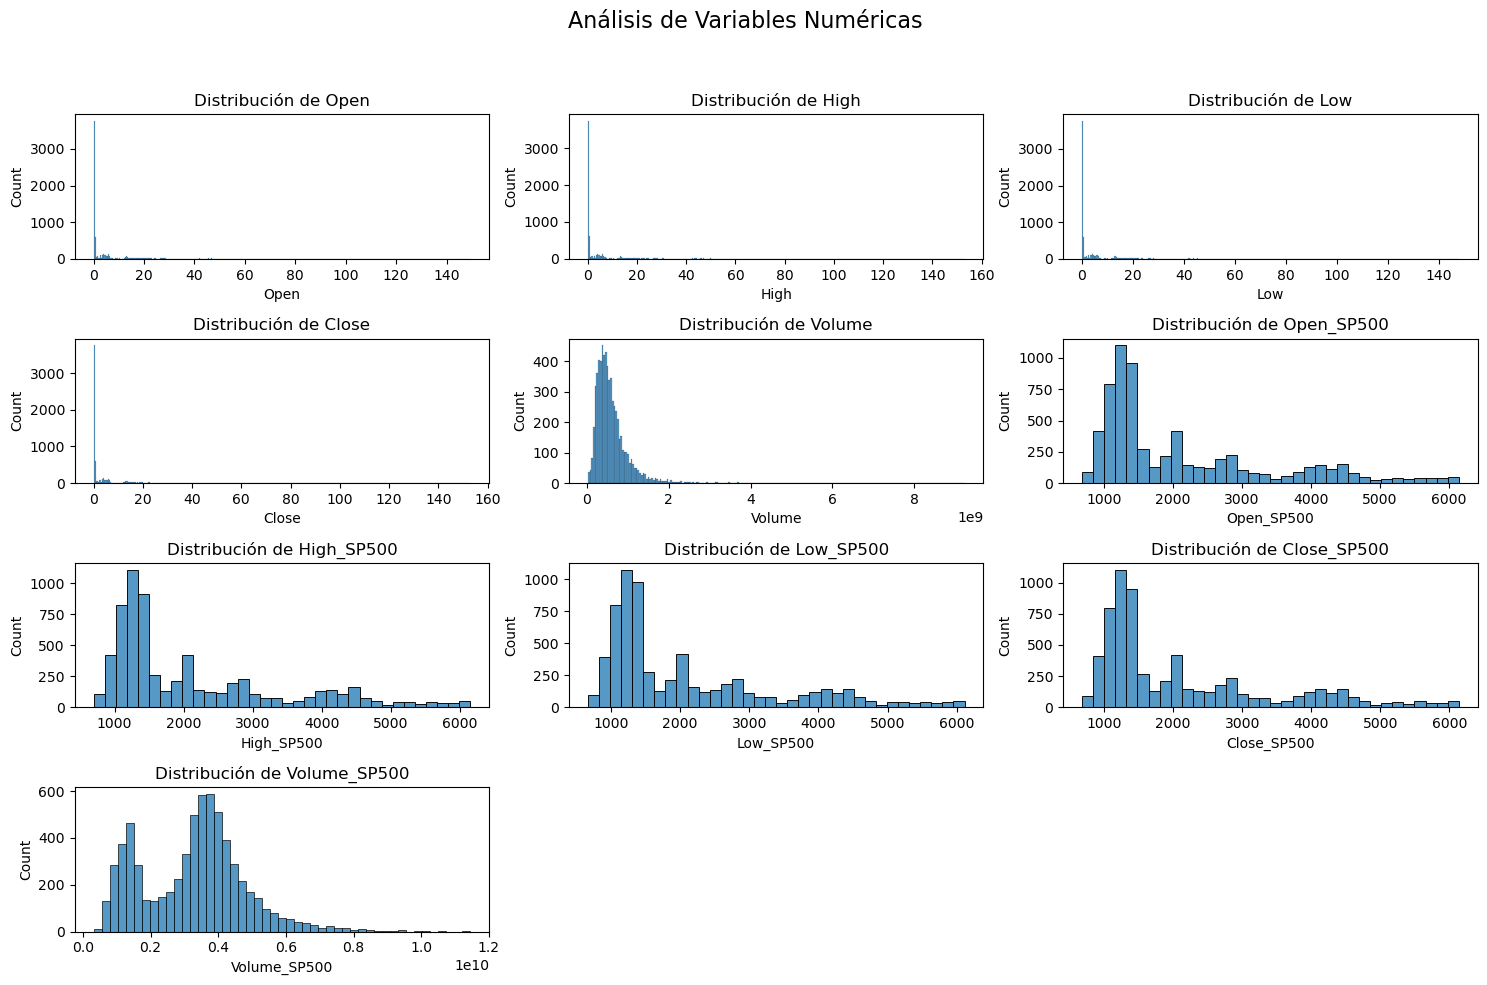

In [42]:
nvidia_data = pd.read_csv('../data/raw/NVDA_with_SP500.csv')
analisis_exploratorio('NVIDIA', nvidia_data)

In [43]:
mask_extreme_upper = iqr_method(nvidia_data['Close'])['extreme_upper']
mask_extreme_lower = iqr_method(nvidia_data['Close'])['extreme_lower']
mask_outliers_upper = iqr_method(nvidia_data['Close'])['outliers_upper']
mask_outliers_lower = iqr_method(nvidia_data['Close'])['outliers_lower']

nvidia_data['Close'][mask_extreme_upper]


5638     18.745481
5639     18.397452
5640     18.433625
5641     18.968779
5642     19.188324
           ...    
6583    120.550003
6584    118.730003
6585    111.349998
6586    111.489998
6587    105.129997
Name: Close, Length: 790, dtype: float64

Aqui de igual forma los outliers son organicos así que no se hace nada

|                                                Análisis de la tabla Google                                                |
Dimensiones: (5187, 11)

Estadísticas descriptivas y problemas de calidad:
|                               | Date            | Open               | High               | Low                | Close              | Volume             | Open_SP500         | High_SP500         | Low_SP500          | Close_SP500        | Volume_SP500       |
|:------------------------------|:----------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| Valores Únicos                | 5187            | 5090               | 5187               | 5187               | 5187               | 5061               | 5133               | 5119               | 5128               | 5125               | 5112               |
| Media      

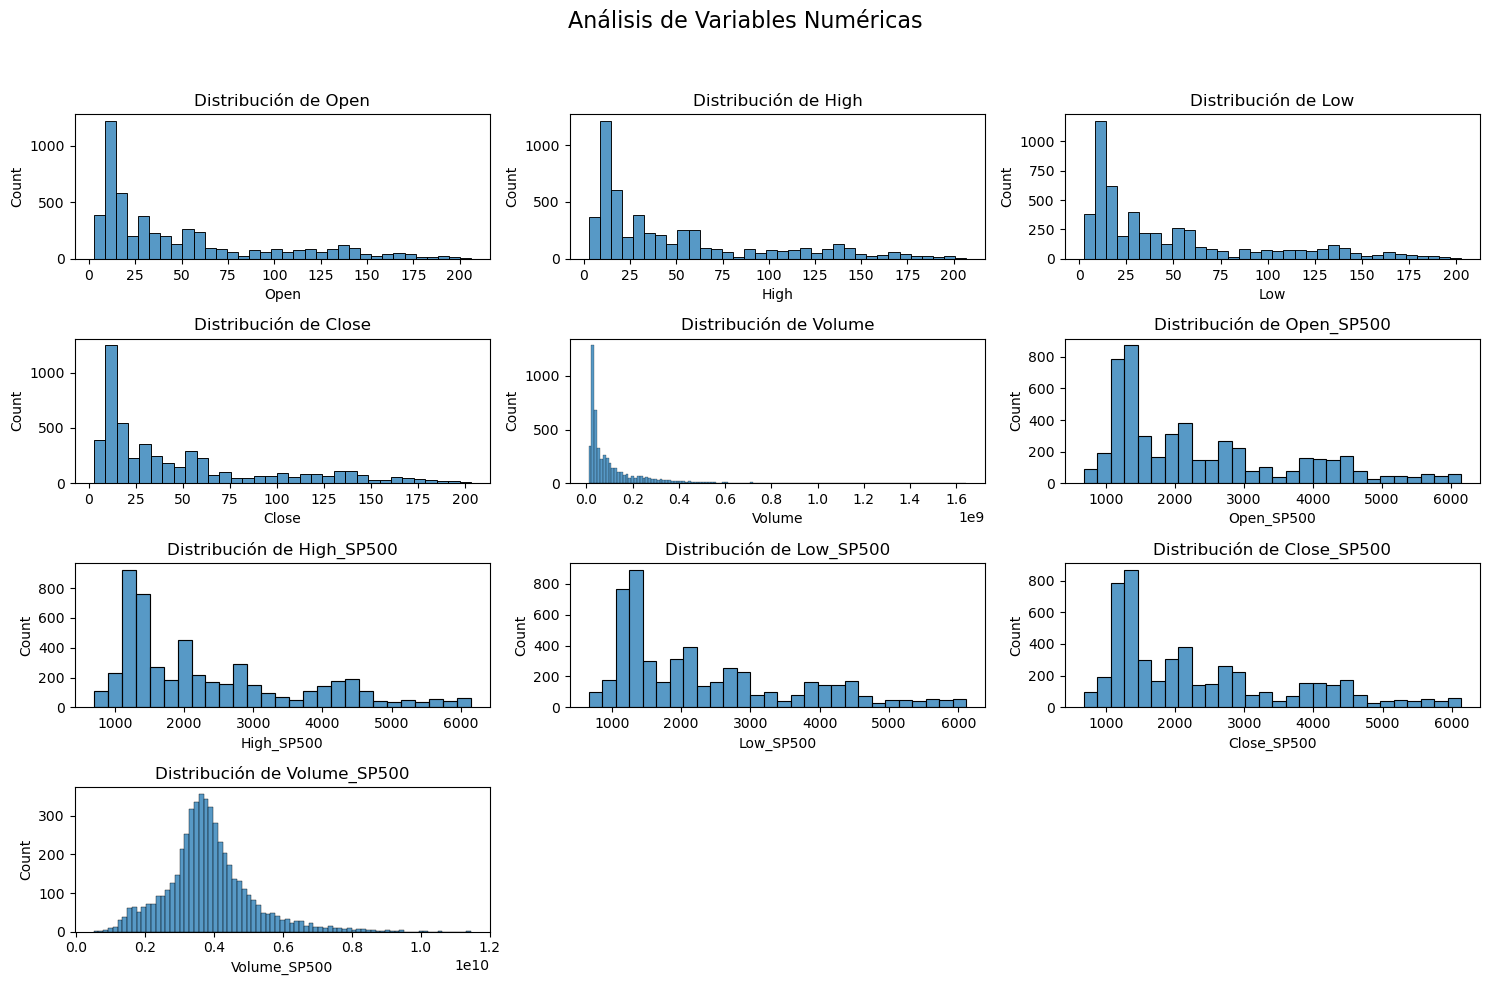

In [44]:
google_data = pd.read_csv('../data/raw/GOOGL_with_SP500.csv')
analisis_exploratorio('Google', google_data)

In [45]:
mask_extreme_upper = iqr_method(google_data['Close'])['extreme_upper']
mask_extreme_lower = iqr_method(google_data['Close'])['extreme_lower']
mask_outliers_upper = iqr_method(google_data['Close'])['outliers_upper']
mask_outliers_lower = iqr_method(google_data['Close'])['outliers_lower']

google_data['Close'][mask_outliers_upper]

4329    146.434389
4331    147.341575
4334    146.424460
4335    148.459717
4336    149.112097
           ...    
5182    168.979996
5183    169.000000
5184    164.630005
5185    160.490005
5186    153.110001
Name: Close, Length: 297, dtype: float64

Y en este dataset igualmente no hacemos nada